In [74]:
import importlib
import modules

import matplotlib.pyplot as plt
import cellpylib as cpl
import numpy as np
import pandas as pd

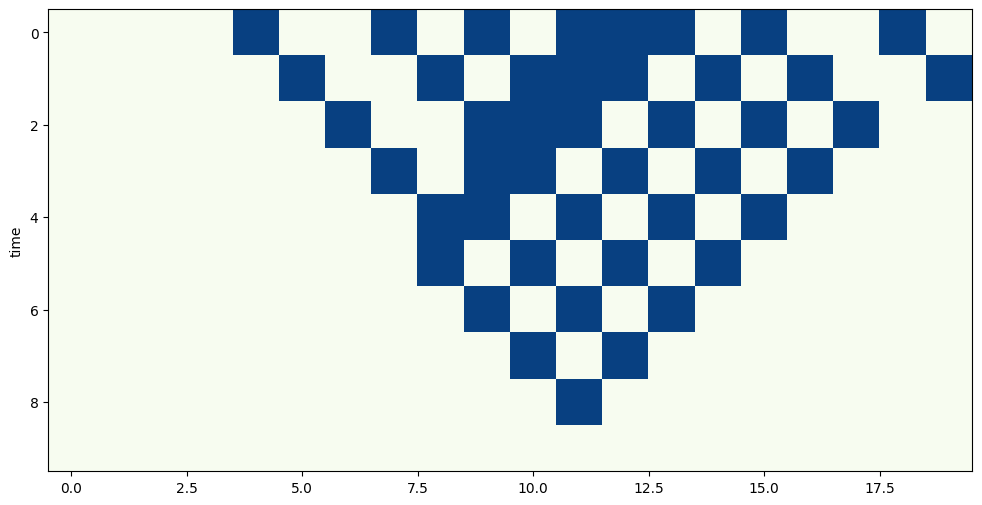

In [75]:
p = 0.5
L = 20
T = int(L / 2)
initial_state = modules.gen_initial_state_bernoulli(L, p)

# print(cellular_automaton)
cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
cellular_automaton = modules.triangulize_evolution(cellular_automaton)

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(cellular_automaton, colormap='GnBu')



In [76]:
importlib.reload(modules)


jam_sizes = modules.find_jams(cellular_automaton)
print(f"The jams in the evolution above are: {jam_sizes}")
print(f"\'[[i, j], size]\' with i and j being the row coordinates in the row that the jam was last found in and size being the size of the jam.")
print(jam_sizes)

print(f"Jam sizes: {jam_sizes}")

The jams in the evolution above are: [14]
'[[i, j], size]' with i and j being the row coordinates in the row that the jam was last found in and size being the size of the jam.
[14]
Jam sizes: [14]


[1, 2, 1, 2, 3, 4, 5, 6, 5, 4]


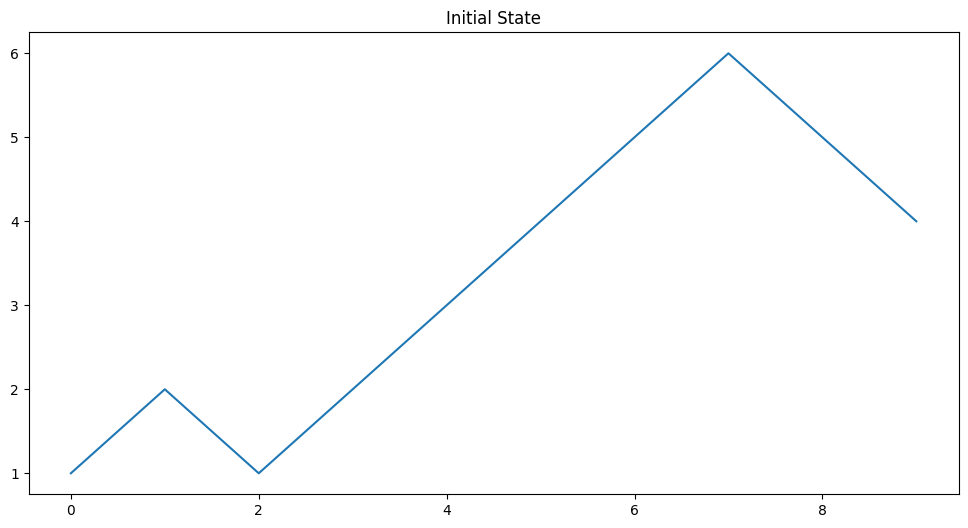

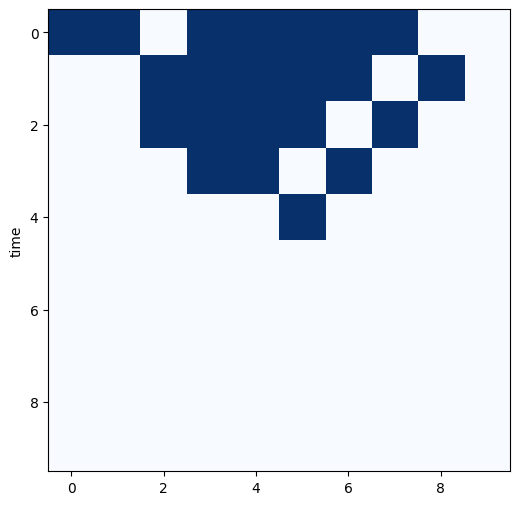

In [77]:
# Plot the random walk that is the initial state, go up for 1, down for 0
initial_state = np.array([[1, 1, 0, 1, 1, 1, 1, 1, 0, 0]])
random_walk = modules.initial_to_random_walk(initial_state)
print(random_walk)
plt.figure(figsize=(12,6))
plt.title(f'Initial State')
plt.plot(random_walk)

cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
cellular_automaton = modules.triangulize_evolution(cellular_automaton)

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(cellular_automaton, colormap='Blues')





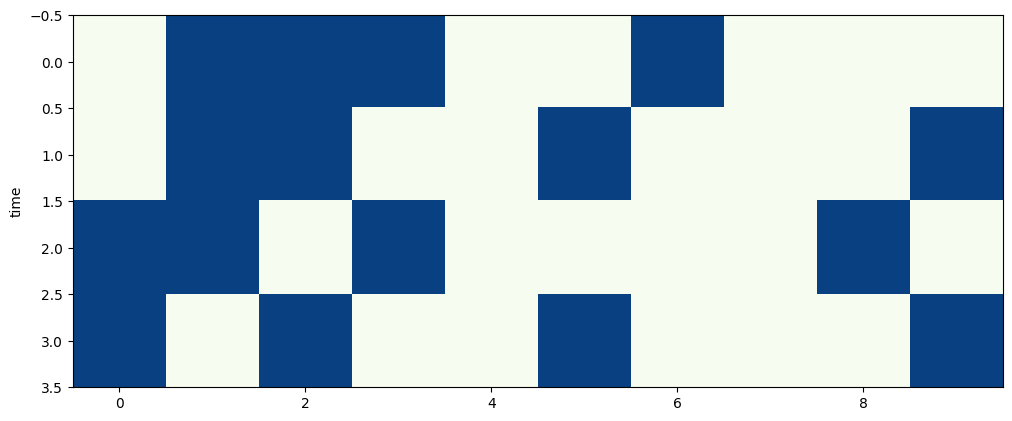

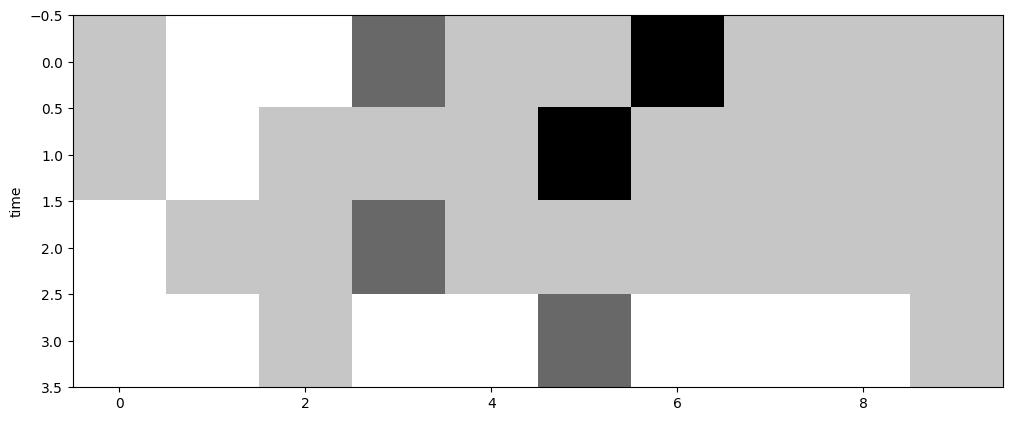

Flow: 14


In [78]:
p = 0.5
L = 10
T = int(L / 2)
T = 3
n = 1

lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(p, L, T, n, v_max=3, p_slowdown = 0, return_evolutions=True)

evolution = evolutions[0]
    
location_evolution = [[x[0] for x in line] for line in evolution]
speed_evolution = [[x[1] for x in line] for line in evolution]

flow = modules.calculate_flow_nasch(evolution)

# plot the car evolution
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(location_evolution, colormap='GnBu')

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(speed_evolution, colormap='Grays')

print(f"Flow: {flow}")




In [82]:
import sys
sys.setrecursionlimit(10000)

Critical density: 0.22040816326530616


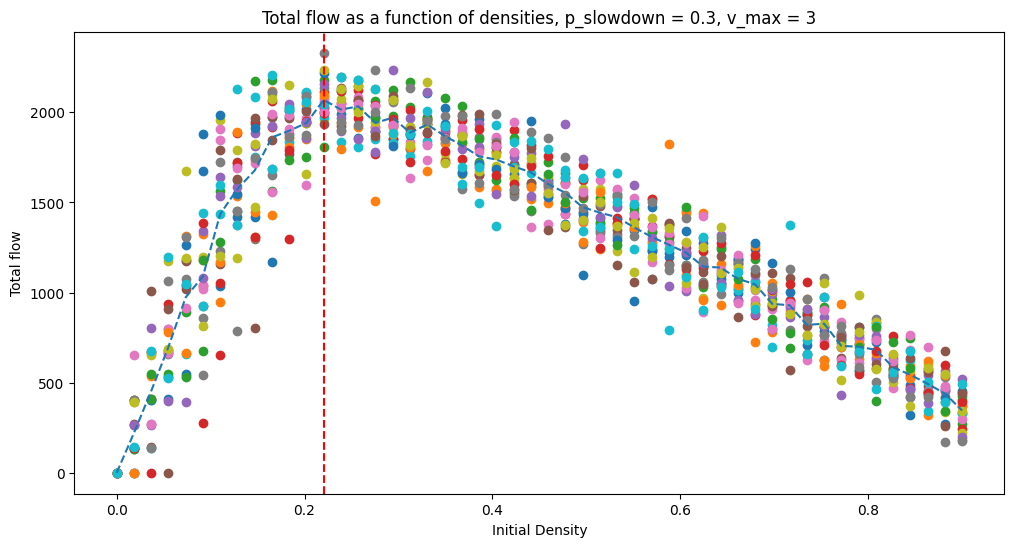

In [87]:
p = np.linspace(0.0, 0.9, 50)
L = 100
T = int(L / 2)
n = 20
p_slowdown = 0.3
v_max = 3

total_flows_per_density = dict()
average_flows_per_density = dict()

for density in p:
    lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, return_evolutions=True)
    

    total_flows = [modules.calculate_flow_nasch(evolution) for evolution in evolutions]
    average_flows = [flow / float(T) for flow in total_flows]
    
    total_flows_per_density[density] = total_flows
    average_flows_per_density[density] = average_flows

# Find critical point: the density for which the total flow average is maximum
mean_total_flow_per_density = {density: np.mean(flows) for density, flows in total_flows_per_density.items()}
critical_density = max(mean_total_flow_per_density, key=mean_total_flow_per_density.get)
print(f"Critical density: {critical_density}")

# plot total flow as a function of densities
plt.figure(figsize=(12,6))
plt.title(f'Total flow as a function of densities, p_slowdown = {p_slowdown}, v_max = {v_max}')
plt.plot(total_flows_per_density.keys(), total_flows_per_density.values(), 'o')
plt.plot(total_flows_per_density.keys(), [np.mean(flows) for flows in total_flows_per_density.values()], '--')

# Add a vertical line at the critical density
plt.axvline(x=critical_density, color='red', linestyle='--')

plt.xlabel('Initial Density')
plt.ylabel('Total flow')
plt.show()

In [ ]:
importlib.reload(modules)

p_values = np.linspace(0.0, 1, 50)
L = 300
T = int(L / 2)
n = 20
p_slowdown_values = np.linspace(0.0, 1, 50)
v_max_values = [x for x in range(1, 11)]
repetitions = 5

output_df = modules.find_critical_dataframe_nasch(p_slowdown_values, v_max_values, p_values, L, T, n, repetitions=repetitions)

# Save the output to a csv file
output_df.to_csv(f'Results\\critical_densities_nasch_n={n}_L={L}_T={T}_#p={len(p_values)}_reps={repetitions}.csv', index=False)

# Plot the output per v_max
for v_max in v_max_values:
    df = output_df[output_df[f'v_max'] == v_max]
    x = list(df['p_slowdown'])
    y = list(df['critical_density']) # multiple values per x
    y_means = [np.mean(l) for l in y]
    plt.figure(figsize=(12,6))
    plt.title(f'Critical density as a function of slowdown probability for v_max={v_max}')
    plt.plot(x, y, 'o', color='blue')
    plt.plot(x, y_means, '-', color='red')
    plt.xlabel('Slowdown probability')
    plt.ylabel('Critical density')
    plt.show()

 11%|█         | 28/250 [07:48<38:31, 10.41s/it]   

In [88]:
def density_evolution_nasch (evolution):
    """
    Function to calculate the density evolution of the NaSch model. The density is defined as the
    amount of cars in total. This is calculated by summing the total amount of cars.
    Input: 
    - evolution (list): List containing the evolution of the model for each timestep.
    Output:
    - density_evolution (list): List containing the density evolution of the model for each timestep.
    """
    location_evolution = [[x[0] for x in line] for line in evolution]
    density_evolution = [np.sum(line) / len(line) for line in location_evolution]
    return density_evolution


Flow: 199289


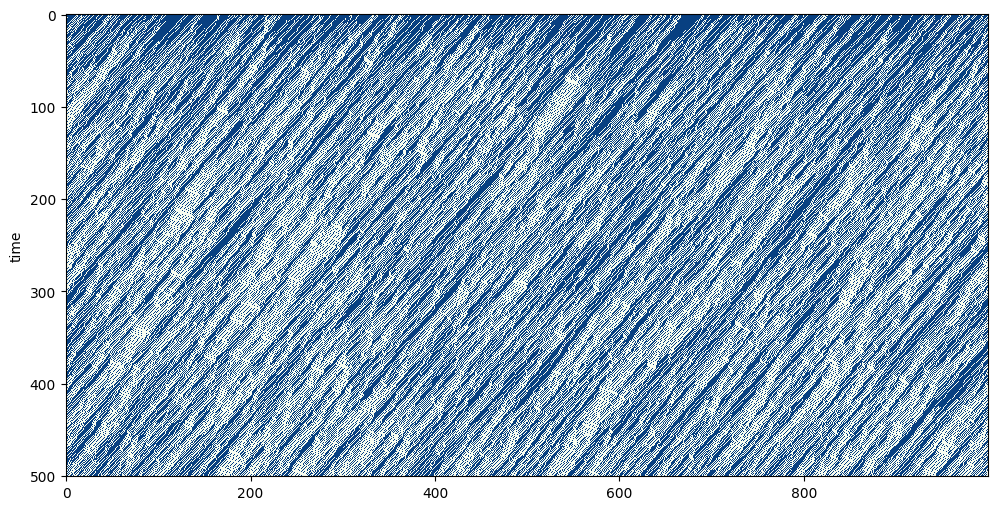

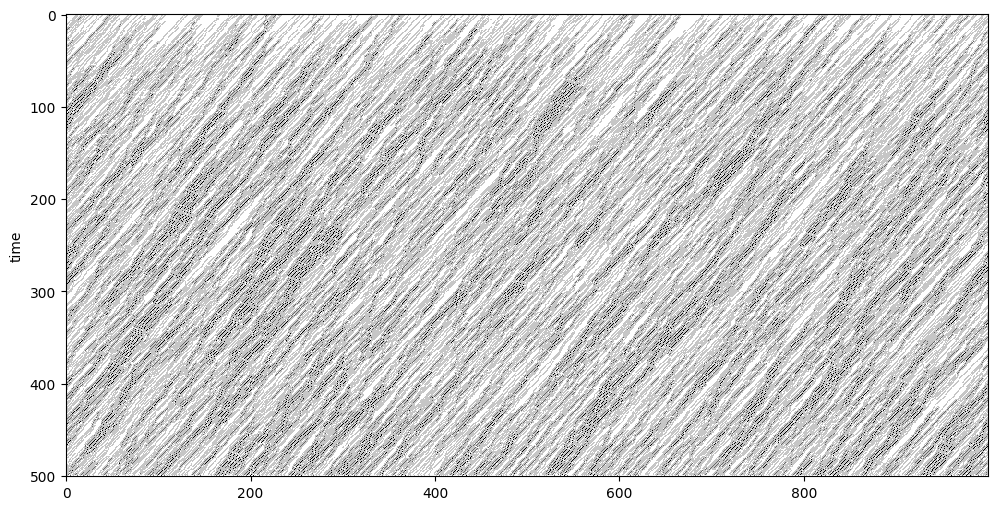

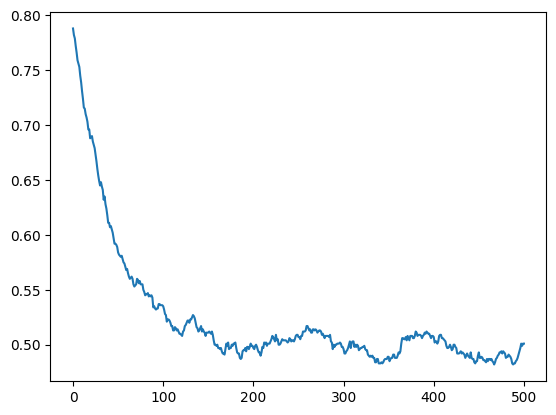

In [92]:
# Test dynamic model
importlib.reload(modules)

initial_density = 0.8
L = 1000
T = 500
n = 1

# NaSch parameters
p_slowdown = 0.1
v_max = 3

# Dynamic parameters
neighbourhood_size = 5
entry_chance = 0.01
exit_chance = 0.01

lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(initial_density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=True, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)

# Visualize the evolution
evolution = evolutions[0]

location_evolution = [[x[0] for x in line] for line in evolution]
speed_evolution = [[x[1] for x in line] for line in evolution]

flow = modules.calculate_flow_nasch(evolution)
print(f"Flow: {flow}")

# plot the car evolution
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(location_evolution, colormap='GnBu')

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(speed_evolution, colormap='Grays')

density_test = density_evolution_nasch(evolution)
plt.plot(density_test)



Cluster Sizes: [4]
Cluster Lifespans: [2]


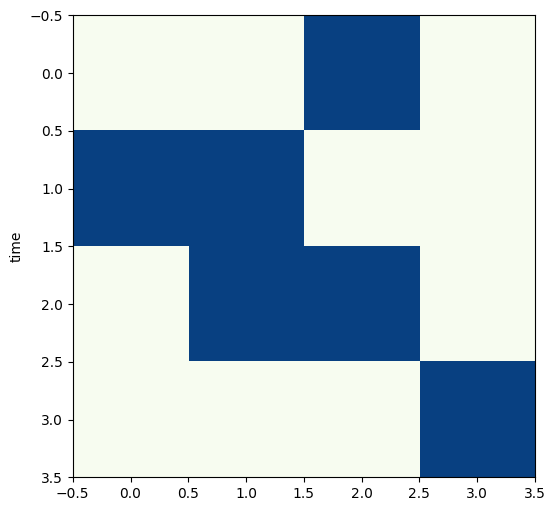

Cluster Sizes: [9, 2]
Cluster Lifespans: [5, 2]


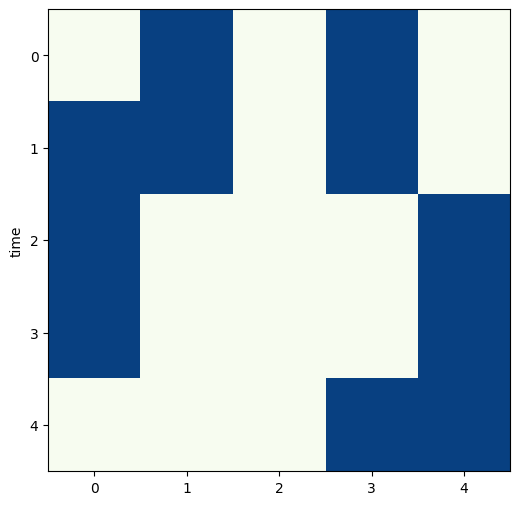

In [90]:
importlib.reload(modules)

modules.test_new_jam_finder()